In [1]:
!pip install "protobuf==3.20.*" --force-reinstall
!pip install -q "monai[nibabel]" --no-deps


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [2]:
import os, random, numpy as np, nibabel as nib, time
from tqdm.auto import tqdm
from glob import glob

import torch, torch.nn as nn
from torch.utils.data import DataLoader

import monai
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    CropForegroundd, NormalizeIntensityd, ResizeWithPadOrCropd,
    ConcatItemsd, EnsureTyped
)
from monai.data import Dataset, CacheDataset
from monai.networks.nets import SwinUNETR
from monai.losses import DiceCELoss, FocalLoss, TverskyLoss
from monai.inferers import sliding_window_inference

print("MONAI:", monai.__version__)
print("Torch:", torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-12-15 18:38:44.276143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765823924.452490      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765823924.510075      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI: 1.5.1
Torch: 2.6.0+cu124
Device: cuda


In [3]:
BASE = "/kaggle/input/brats20-dataset-training-validation"

TRAIN_DIR = f"{BASE}/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
VAL_DIR   = f"{BASE}/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"
TEST_DIR  = VAL_DIR  # No labels provided, will use for inference only

IMG_SIZE = (96, 96, 96)
IN_CHANNELS = 4
OUT_CHANNELS = 4   # 0,1,2,3 (we remap 4->3)
BATCH_SIZE = 1
EPOCHS = 60
LR = 1e-4

OUTDIR = "/kaggle/working/swin_unetr_run"
CKPT_DIR = f"{OUTDIR}/checkpoints"; os.makedirs(CKPT_DIR, exist_ok=True)
PRED_DIR = f"{OUTDIR}/predictions"; os.makedirs(PRED_DIR, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

print("OUTPUT DIR:", OUTDIR)


OUTPUT DIR: /kaggle/working/swin_unetr_run


In [4]:
def load_brats_train(root):
    items = []
    for case in sorted(os.listdir(root)):
        folder = f"{root}/{case}"

        # Skip junk files / CSV / non-directories
        if not os.path.isdir(folder): 
            continue
        if case.endswith(".csv") or case.startswith("."):
            continue
        
        cid = case
        
        f = f"{folder}/{cid}_flair.nii"
        t1 = f"{folder}/{cid}_t1.nii"
        t1ce = f"{folder}/{cid}_t1ce.nii"
        t2 = f"{folder}/{cid}_t2.nii"
        seg = f"{folder}/{cid}_seg.nii"

        # Make sure ALL 4 modalities + seg exist
        if os.path.exists(f) and os.path.exists(t1) and os.path.exists(t1ce) and os.path.exists(t2) and os.path.exists(seg):
            items.append({"id": cid, "flair": f, "t1": t1, "t1ce": t1ce, "t2": t2, "seg": seg})
    
    return items


def load_brats_test(root):
    items = []
    for case in sorted(os.listdir(root)):
        folder = f"{root}/{case}"
        if not os.path.isdir(folder): 
            continue
        if case.endswith(".csv") or case.startswith("."):
            continue

        cid = case
        f = f"{folder}/{cid}_flair.nii"
        t1 = f"{folder}/{cid}_t1.nii"
        t1ce = f"{folder}/{cid}_t1ce.nii"
        t2 = f"{folder}/{cid}_t2.nii"

        if os.path.exists(f) and os.path.exists(t1) and os.path.exists(t1ce) and os.path.exists(t2):
            items.append({"id": cid, "flair": f, "t1": t1, "t1ce": t1ce, "t2": t2})
    return items


train_files = load_brats_train(TRAIN_DIR)
test_files  = load_brats_test(TEST_DIR)

print("Train cases:", len(train_files))
print("Test cases:", len(test_files))


Train cases: 368
Test cases: 125


In [5]:
train_transforms = monai.transforms.Compose([
    LoadImaged(keys=["flair","t1","t1ce","t2","seg"]),
    EnsureChannelFirstd(keys=["flair","t1","t1ce","t2","seg"]),
    Orientationd(keys=["flair","t1","t1ce","t2","seg"], axcodes="RAS"),
    Spacingd(keys=["flair","t1","t1ce","t2","seg"],
             pixdim=(1,1,1), mode=("bilinear","bilinear","bilinear","bilinear","nearest")),
    CropForegroundd(keys=["flair","t1","t1ce","t2","seg"], source_key="flair"),
    ResizeWithPadOrCropd(keys=["flair","t1","t1ce","t2","seg"], spatial_size=IMG_SIZE),
    NormalizeIntensityd(keys=["flair","t1","t1ce","t2"], nonzero=True, channel_wise=True),
    ConcatItemsd(keys=["flair","t1","t1ce","t2"], name="image"),
    EnsureTyped(keys=["image","seg"])
])

test_transforms = monai.transforms.Compose([
    LoadImaged(keys=["flair","t1","t1ce","t2"]),
    EnsureChannelFirstd(keys=["flair","t1","t1ce","t2"]),
    Orientationd(keys=["flair","t1","t1ce","t2"], axcodes="RAS"),
    Spacingd(keys=["flair","t1","t1ce","t2"], pixdim=(1,1,1),
             mode=("bilinear","bilinear","bilinear","bilinear")),
    CropForegroundd(keys=["flair","t1","t1ce","t2"], source_key="flair"),
    ResizeWithPadOrCropd(keys=["flair","t1","t1ce","t2"], spatial_size=IMG_SIZE),
    NormalizeIntensityd(keys=["flair","t1","t1ce","t2"], nonzero=True, channel_wise=True),
    ConcatItemsd(keys=["flair","t1","t1ce","t2"], name="image"),
    EnsureTyped(keys=["image"])
])


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [6]:
train_ds = CacheDataset(train_files, transform=train_transforms, cache_rate=0.7)
test_ds  = Dataset(test_files, transform=test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(train_ds, batch_size=1, shuffle=False)  # since training has labels
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

print("Batches => Train:", len(train_loader), "Val:", len(val_loader), "Test:", len(test_loader))


Loading dataset: 100%|██████████| 257/257 [07:58<00:00,  1.86s/it]

Batches => Train: 368 Val: 368 Test: 125


In [7]:
model = SwinUNETR(
       
    in_channels=4,
    out_channels=4,
    feature_size=48,
    use_checkpoint=True
).to(device)


loss_dicece = DiceCELoss(include_background=False, to_onehot_y=True, softmax=True)
loss_tversky = TverskyLoss(alpha=0.3, beta=0.7, to_onehot_y=True, softmax=True)
loss_focal = FocalLoss(include_background=False, to_onehot_y=True, gamma=2.0)

def hybrid_loss(pred, target):
    target[target == 4] = 3
    l1 = loss_dicece(pred, target)
    l2 = loss_tversky(pred, target)
    l3 = loss_focal(pred, target)
    return 0.4*l1 + 0.3*l2 + 0.3*l3

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()


/tmp/ipykernel_20/3709581165.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [8]:
def dice_region(pred, gt):
    pred = pred.cpu().numpy()[0]
    gt   = gt.cpu().numpy()[0]
    gt[gt==4] = 3

    eps = 1e-7
    scores = {}
    scores["WT"] = (2*np.sum((pred>0)&(gt>0))) / (np.sum(pred>0)+np.sum(gt>0)+eps)
    scores["TC"] = (2*np.sum(((pred==1)|(pred==3)) & ((gt==1)|(gt==3)))) / (
                   np.sum((pred==1)|(pred==3))+np.sum((gt==1)|(gt==3))+eps)
    scores["ET"] = (2*np.sum((pred==3)&(gt==3))) / (np.sum(pred==3)+np.sum(gt==3)+eps)
    return scores


ckpt = torch.load(f"{CKPT_DIR}/best_swin_hybrid.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
optimizer.load_state_dict(ckpt["optimizer_state"])
start_epoch = ckpt["epoch"] + 1
print("🔄 Resuming Training from Epoch", start_epoch)
for epoch in range(start_epoch, EPOCHS+1):


In [9]:
best_dice = 0
per_class_dice_history = []   
train_losses = []             

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0

    # ================== TRAIN ==================
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for batch in pbar:
        img = batch["image"].to(device)
        seg = batch["seg"].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            pred = model(img)
            loss = hybrid_loss(pred, seg)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        pbar.set_postfix({"loss": f"{running_loss/(pbar.n+1):.4f}"})

    # ================== VALIDATION ==================
    model.eval()
    dices = {"WT":[], "TC":[], "ET":[]}

    with torch.no_grad():
        vbar = tqdm(val_loader, desc="Validating", leave=False)
        for v in vbar:
            img = v["image"].to(device)
            seg = v["seg"].to(device)

            out = sliding_window_inference(img, IMG_SIZE, 1, model)
            pred = torch.argmax(out.softmax(1), 1, keepdim=True)
            d = dice_region(pred, seg)
            for k in d:
                dices[k].append(d[k])

    mean_dice = np.mean([np.mean(v) for v in dices.values()])
    print(f"🎯 Dice -> WT:{np.mean(dices['WT']):.4f}, TC:{np.mean(dices['TC']):.4f}, ET:{np.mean(dices['ET']):.4f}, Mean:{mean_dice:.4f}")

    # ---- Save epoch metrics ----
    per_class_dice_history.append([
        np.mean(dices["WT"]),
        np.mean(dices["TC"]),
        np.mean(dices["ET"])
    ])
    train_losses.append(running_loss/(len(train_loader)))

    # ---- Save BEST Model with optimizer ----
    if mean_dice > best_dice:
        best_dice = mean_dice
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "best_dice": best_dice
        }, f"{CKPT_DIR}/best_swin_hybrid.pth")
        print("💾 Saved BEST model (with optimizer)!")

# ================== SAVE LAST EPOCH MODEL ==================
torch.save(model.state_dict(), f"{CKPT_DIR}/last_epoch_swin_hybrid.pth")
print("📌 Saved LAST epoch model!")

# ================== SAVE TRAINING METRICS ==================
import pandas as pd

df = pd.DataFrame(per_class_dice_history, columns=["WT","TC","ET"])
df["Mean"] = df.mean(axis=1)
df["Train_Loss"] = train_losses
df.to_csv(f"{OUTDIR}/metrics_log.csv", index_label="Epoch")

print("📊 Metrics saved to:", f"{OUTDIR}/metrics_log.csv")


Epoch 1/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.8486, TC:0.6670, ET:0.6400, Mean:0.7185
💾 Saved BEST model (with optimizer)!


Epoch 2/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.8818, TC:0.6950, ET:0.6865, Mean:0.7544
💾 Saved BEST model (with optimizer)!


Epoch 3/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.8809, TC:0.7557, ET:0.7028, Mean:0.7798
💾 Saved BEST model (with optimizer)!


Epoch 4/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9022, TC:0.7689, ET:0.7160, Mean:0.7957
💾 Saved BEST model (with optimizer)!


Epoch 5/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.8928, TC:0.7662, ET:0.7175, Mean:0.7922


Epoch 6/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9072, TC:0.8170, ET:0.7298, Mean:0.8180
💾 Saved BEST model (with optimizer)!


Epoch 7/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9126, TC:0.7956, ET:0.7163, Mean:0.8082


Epoch 8/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9143, TC:0.7850, ET:0.7352, Mean:0.8115


Epoch 9/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9179, TC:0.8268, ET:0.7335, Mean:0.8261
💾 Saved BEST model (with optimizer)!


Epoch 10/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9209, TC:0.8423, ET:0.7501, Mean:0.8378
💾 Saved BEST model (with optimizer)!


Epoch 11/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9181, TC:0.8230, ET:0.7461, Mean:0.8291


Epoch 12/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9126, TC:0.8576, ET:0.7553, Mean:0.8418
💾 Saved BEST model (with optimizer)!


Epoch 13/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9172, TC:0.8541, ET:0.7534, Mean:0.8416


Epoch 14/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9112, TC:0.8590, ET:0.7555, Mean:0.8419
💾 Saved BEST model (with optimizer)!


Epoch 15/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9234, TC:0.8705, ET:0.7619, Mean:0.8519
💾 Saved BEST model (with optimizer)!


Epoch 16/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9184, TC:0.8054, ET:0.7565, Mean:0.8268


Epoch 17/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9262, TC:0.8726, ET:0.7631, Mean:0.8540
💾 Saved BEST model (with optimizer)!


Epoch 18/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9302, TC:0.8744, ET:0.7701, Mean:0.8582
💾 Saved BEST model (with optimizer)!


Epoch 19/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9244, TC:0.8686, ET:0.7638, Mean:0.8523


Epoch 20/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9287, TC:0.8835, ET:0.7709, Mean:0.8611
💾 Saved BEST model (with optimizer)!


Epoch 21/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9328, TC:0.8865, ET:0.7755, Mean:0.8649
💾 Saved BEST model (with optimizer)!


Epoch 22/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9341, TC:0.8943, ET:0.7677, Mean:0.8654
💾 Saved BEST model (with optimizer)!


Epoch 23/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9346, TC:0.8981, ET:0.7726, Mean:0.8684
💾 Saved BEST model (with optimizer)!


Epoch 24/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9349, TC:0.8977, ET:0.7773, Mean:0.8700
💾 Saved BEST model (with optimizer)!


Epoch 25/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9295, TC:0.8977, ET:0.7773, Mean:0.8682


Epoch 26/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9337, TC:0.8992, ET:0.7806, Mean:0.8712
💾 Saved BEST model (with optimizer)!


Epoch 27/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9274, TC:0.9030, ET:0.7786, Mean:0.8696


Epoch 28/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9309, TC:0.9053, ET:0.7806, Mean:0.8723
💾 Saved BEST model (with optimizer)!


Epoch 29/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9372, TC:0.9079, ET:0.7792, Mean:0.8748
💾 Saved BEST model (with optimizer)!


Epoch 30/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9380, TC:0.9092, ET:0.7842, Mean:0.8771
💾 Saved BEST model (with optimizer)!


Epoch 31/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9356, TC:0.8777, ET:0.7705, Mean:0.8613


Epoch 32/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9334, TC:0.8974, ET:0.7765, Mean:0.8691


Epoch 33/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9398, TC:0.9104, ET:0.7805, Mean:0.8769


Epoch 34/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9352, TC:0.8979, ET:0.7803, Mean:0.8711


Epoch 35/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9380, TC:0.9110, ET:0.7827, Mean:0.8772
💾 Saved BEST model (with optimizer)!


Epoch 36/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9392, TC:0.8944, ET:0.7868, Mean:0.8735


Epoch 37/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9370, TC:0.9182, ET:0.7932, Mean:0.8828
💾 Saved BEST model (with optimizer)!


Epoch 38/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9353, TC:0.9024, ET:0.7856, Mean:0.8745


Epoch 39/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9452, TC:0.9192, ET:0.7957, Mean:0.8867
💾 Saved BEST model (with optimizer)!


Epoch 40/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9456, TC:0.9214, ET:0.7992, Mean:0.8887
💾 Saved BEST model (with optimizer)!


Epoch 41/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9384, TC:0.9178, ET:0.7922, Mean:0.8828


Epoch 42/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9409, TC:0.9176, ET:0.7988, Mean:0.8858


Epoch 43/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9437, TC:0.9016, ET:0.7966, Mean:0.8806


Epoch 44/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9469, TC:0.9213, ET:0.7990, Mean:0.8891
💾 Saved BEST model (with optimizer)!


Epoch 45/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9468, TC:0.9266, ET:0.8033, Mean:0.8922
💾 Saved BEST model (with optimizer)!


Epoch 46/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9427, TC:0.9258, ET:0.8031, Mean:0.8905


Epoch 47/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9402, TC:0.9195, ET:0.7992, Mean:0.8863


Epoch 48/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9416, TC:0.9190, ET:0.8023, Mean:0.8876


Epoch 49/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9438, TC:0.9228, ET:0.8002, Mean:0.8889


Epoch 50/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9436, TC:0.9245, ET:0.7944, Mean:0.8875


Epoch 51/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9495, TC:0.9296, ET:0.8067, Mean:0.8953
💾 Saved BEST model (with optimizer)!


Epoch 52/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9507, TC:0.9308, ET:0.8074, Mean:0.8963
💾 Saved BEST model (with optimizer)!


Epoch 53/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9505, TC:0.9302, ET:0.8081, Mean:0.8963


Epoch 54/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9504, TC:0.9265, ET:0.7898, Mean:0.8889


Epoch 55/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9519, TC:0.9299, ET:0.8066, Mean:0.8962


Epoch 56/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9511, TC:0.9315, ET:0.8117, Mean:0.8981
💾 Saved BEST model (with optimizer)!


Epoch 57/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9481, TC:0.9320, ET:0.8164, Mean:0.8988
💾 Saved BEST model (with optimizer)!


Epoch 58/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9527, TC:0.9330, ET:0.8172, Mean:0.9010
💾 Saved BEST model (with optimizer)!


Epoch 59/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9518, TC:0.9339, ET:0.8165, Mean:0.9008


Epoch 60/60:   0%|          | 0/368 [00:00<?, ?it/s]

Validating:   0%|          | 0/368 [00:00<?, ?it/s]

🎯 Dice -> WT:0.9543, TC:0.9353, ET:0.8162, Mean:0.9019
💾 Saved BEST model (with optimizer)!
📌 Saved LAST epoch model!
📊 Metrics saved to: /kaggle/working/swin_unetr_run/metrics_log.csv


In [10]:
import os
import torch

# =========================
# DEVICE
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =========================
# CHECKPOINT DIRECTORY
# =========================
RUN_DIR = "/kaggle/working/swin_unetr_run"
CKPT_DIR = os.path.join(RUN_DIR, "checkpoints")

assert os.path.exists(CKPT_DIR), f"Checkpoint folder not found: {CKPT_DIR}"

print("📁 Checkpoint directory contents:")
print(os.listdir(CKPT_DIR))

# =========================
# LOAD CHECKPOINT (AUTO)
# =========================
ckpt_files = sorted([f for f in os.listdir(CKPT_DIR) if f.endswith(".pth")])

if len(ckpt_files) == 0:
    raise FileNotFoundError("❌ No .pth checkpoint found!")

ckpt_path = os.path.join(CKPT_DIR, ckpt_files[-1])
print("📦 Loading checkpoint:", ckpt_path)

ckpt = torch.load(ckpt_path, map_location=device)

# =========================
# SAFE MODEL LOADING
# =========================
def load_checkpoint_safely(model, ckpt, device):
    """
    Handles:
    - raw state_dict
    - {'model_state': ...}
    - {'state_dict': ...}
    - {'model': ...}
    - {'net': ...}
    """
    if isinstance(ckpt, dict):
        for key in ["model_state", "state_dict", "model", "net"]:
            if key in ckpt:
                model.load_state_dict(ckpt[key])
                print(f"✔ Loaded weights from ckpt['{key}']")
                break
        else:
            # raw state_dict
            model.load_state_dict(ckpt)
            print("✔ Loaded raw state_dict")
    else:
        model.load_state_dict(ckpt)
        print("✔ Loaded raw checkpoint")

    model.to(device)
    model.eval()

# =========================
# LOAD MODEL
# =========================
load_checkpoint_safely(model, ckpt, device)

print("🎉 SwinUNETR model loaded successfully!")


Using device: cuda
📁 Checkpoint directory contents:
['last_epoch_swin_hybrid.pth', 'best_swin_hybrid.pth']
📦 Loading checkpoint: /kaggle/working/swin_unetr_run/checkpoints/last_epoch_swin_hybrid.pth
✔ Loaded raw state_dict
🎉 SwinUNETR model loaded successfully!


In [11]:
import numpy as np
import torch.serialization as serialization

# allow numpy scalar (needed in PyTorch 2.6+)
serialization.add_safe_globals([np.generic])

# Load checkpoint safely
ckpt = torch.load(
    f"{CKPT_DIR}/best_swin_hybrid.pth", 
    map_location=device, 
    weights_only=False
)

# Restore model
model.load_state_dict(ckpt["model_state"])
model.eval()


SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(4, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_feature

In [12]:
for batch in tqdm(test_loader, desc="Inference"):
    pid = batch["id"][0]
    img = batch["image"].to(device)

    out = sliding_window_inference(img, IMG_SIZE, 1, model)
    pred = torch.argmax(out.softmax(1), 1).cpu().numpy()[0]

    affine = np.eye(4)
    for key in ["flair","t1","t1ce","t2"]:
        if key in batch and hasattr(batch[key][0], "meta"):
            try:
                affine = nib.load(batch[key][0].meta["filename_or_obj"]).affine
                break
            except:
                pass

    nib.save(
        nib.Nifti1Image(pred.astype(np.uint8), affine),
        f"{PRED_DIR}/{pid}_pred.nii.gz"
    )


Inference:   0%|          | 0/125 [00:00<?, ?it/s]


📌 Metrics saved at: /kaggle/working/swin_unetr_run/metrics_log.csv


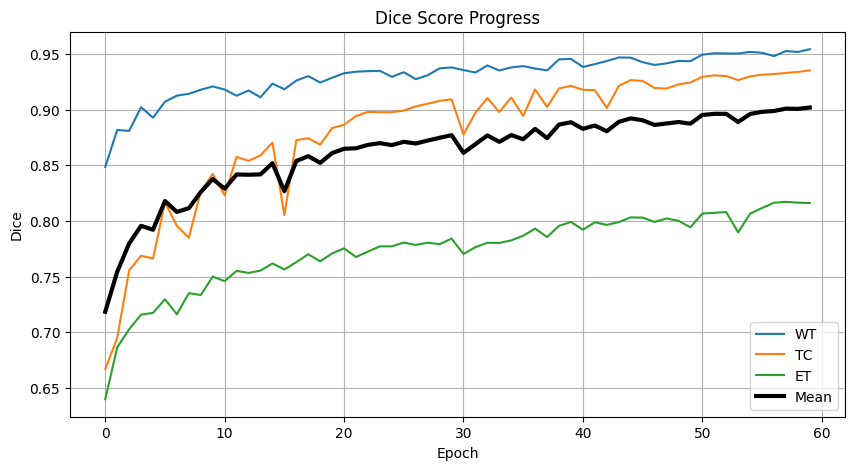

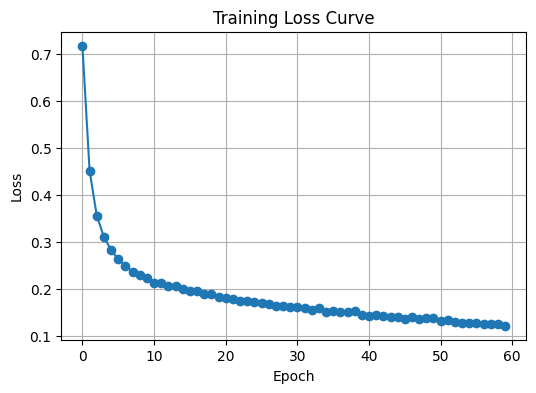

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ===================== SAVE RESULTS =====================
df = pd.DataFrame(per_class_dice_history, columns=["WT","TC","ET"])
df["Mean"] = df.mean(axis=1)
df["Train_Loss"] = train_losses
df.to_csv(f"{OUTDIR}/metrics_log.csv", index_label="Epoch")

print("\n📌 Metrics saved at:", f"{OUTDIR}/metrics_log.csv")

# ===================== PLOT DICE CURVES =====================
plt.figure(figsize=(10,5))
plt.plot(df["WT"], label="WT")
plt.plot(df["TC"], label="TC")
plt.plot(df["ET"], label="ET")
plt.plot(df["Mean"], label="Mean", linewidth=3, color="black")
plt.title("Dice Score Progress")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.grid()
plt.savefig(f"{OUTDIR}/dice_curve.png", dpi=200)
plt.show()

# ===================== PLOT LOSS =====================
plt.figure(figsize=(6,4))
plt.plot(df["Train_Loss"], marker="o")
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.savefig(f"{OUTDIR}/loss_curve.png", dpi=200)
plt.show()


⚠️ No ground-truth available — visualization only


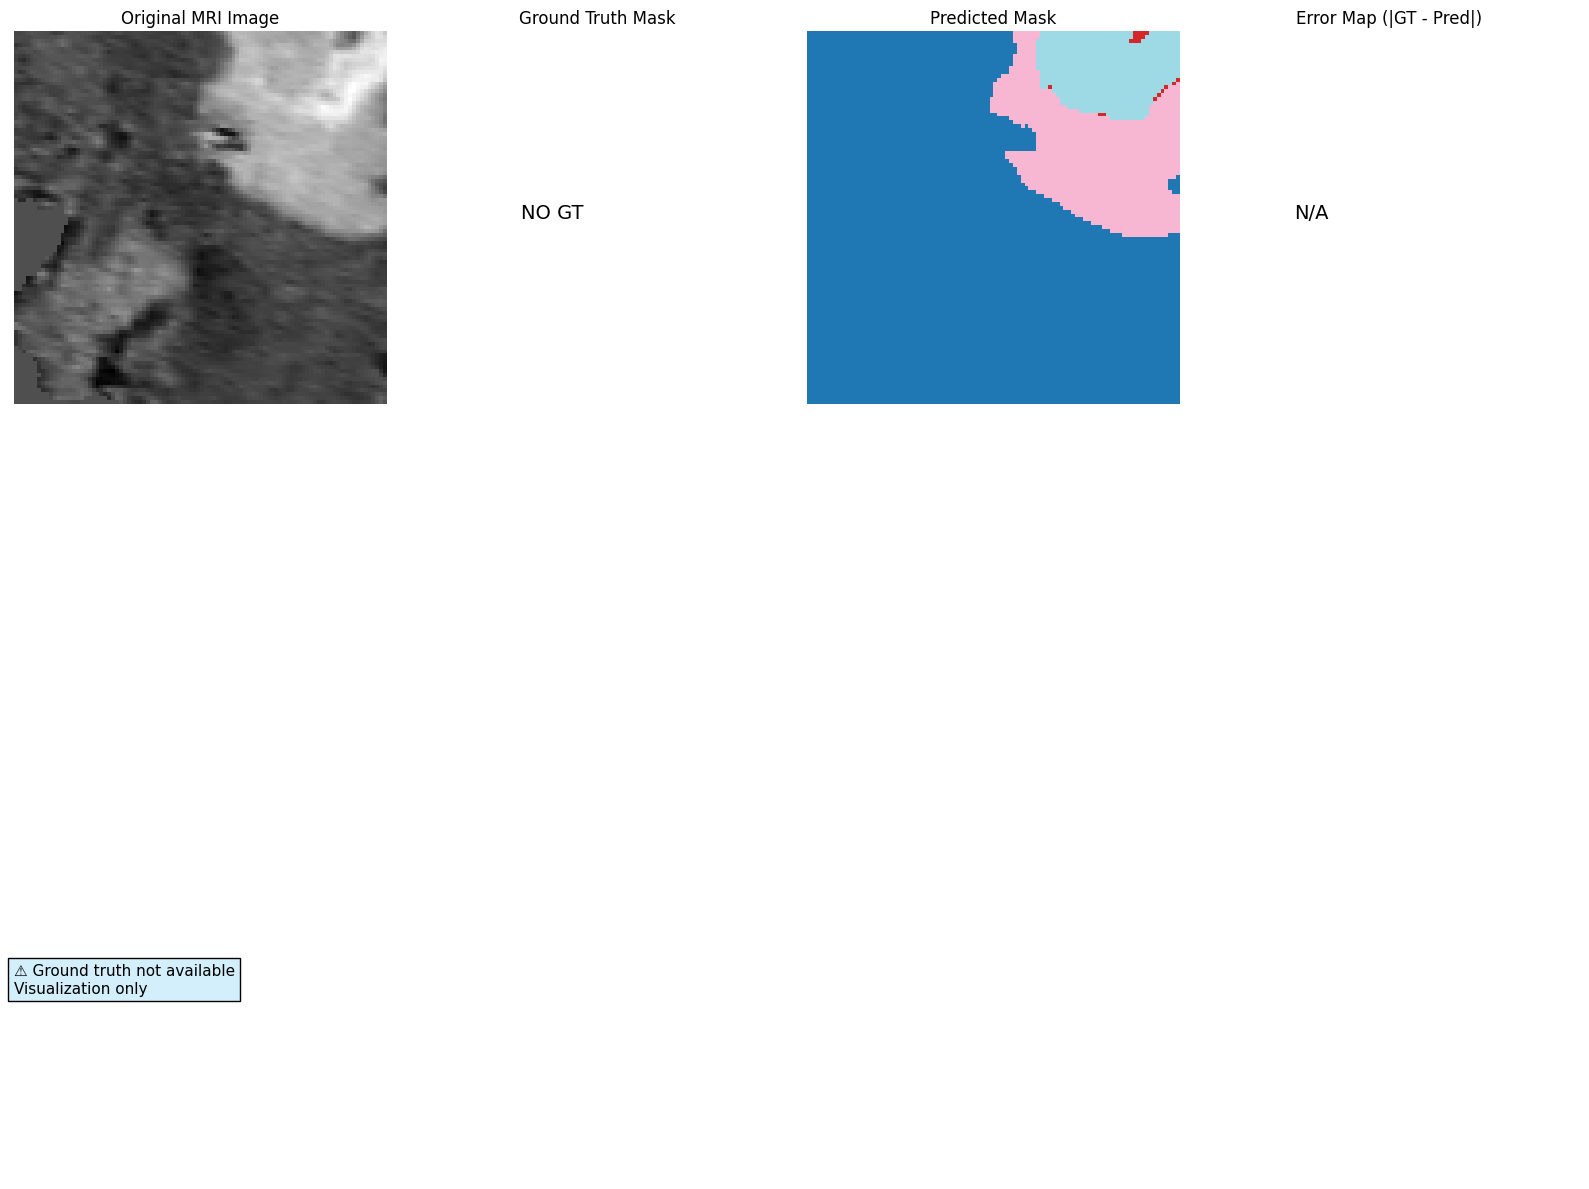

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from monai.inferers import sliding_window_inference

# --------------------------
# Utility for Dice
# --------------------------
def dice_coef(pred, gt, cls):
    pred_c = (pred == cls)
    gt_c   = (gt == cls)
    if gt_c.sum() == 0 and pred_c.sum() == 0:
        return 1.0
    return (2 * np.logical_and(pred_c, gt_c).sum()) / (pred_c.sum() + gt_c.sum() + 1e-8)

# --------------------------
# PICK SAMPLE
# --------------------------
sample = next(iter(test_loader))
img = sample["image"].to(device)

with torch.no_grad():
    out = sliding_window_inference(img, IMG_SIZE, 1, model)

pred = torch.argmax(out.softmax(1), 1).cpu().numpy()[0]

# --------------------------
# SAFE GT EXTRACTION
# --------------------------
gt_tensor = None
for k in ["seg", "label", "mask"]:
    if k in sample:
        gt_tensor = sample[k]
        break

has_gt = gt_tensor is not None

if has_gt:
    gt = gt_tensor[0, 0].cpu().numpy()
    slice_id = np.argmax((gt > 0).sum(axis=(1,2)))
else:
    gt = None
    slice_id = np.argmax(pred.sum(axis=(1,2)))
    print("⚠️ No ground-truth available — visualization only")

# --------------------------
# SLICES
# --------------------------
mri_slice  = img[0, 0, slice_id].cpu().numpy()
pred_slice = pred[slice_id]
gt_slice   = gt[slice_id] if has_gt else None
error_map  = np.abs(gt_slice - pred_slice) if has_gt else None

# --------------------------
# DICE SCORES
# --------------------------
if has_gt:
    dice_ET = dice_coef(pred, gt, 3)
    dice_TC = dice_coef(pred, gt, 2)
    dice_WT = dice_coef(pred, gt, 1)
    dice_BG = dice_coef(pred, gt, 0)
else:
    dice_ET = dice_TC = dice_WT = dice_BG = np.nan

# --------------------------
# PLOT
# --------------------------
plt.figure(figsize=(16,12))

# 1) MRI
plt.subplot(3,4,1)
plt.title("Original MRI Image")
plt.imshow(mri_slice, cmap='gray')
plt.axis('off')

# 2) Ground truth
plt.subplot(3,4,2)
plt.title("Ground Truth Mask")
if has_gt:
    plt.imshow(gt_slice, cmap='tab20')
else:
    plt.text(0.3, 0.5, "NO GT", fontsize=14)
plt.axis('off')

# 3) Prediction
plt.subplot(3,4,3)
plt.title("Predicted Mask")
plt.imshow(pred_slice, cmap='tab20')
plt.axis('off')

# 4) Error Map
plt.subplot(3,4,4)
plt.title("Error Map (|GT - Pred|)")
if has_gt:
    plt.imshow(error_map, cmap='Reds')
    plt.colorbar(label="Error")
else:
    plt.text(0.25, 0.5, "N/A", fontsize=14)
plt.axis('off')

# --------------------------
# Per-Class Overlays
# --------------------------
def masked_overlay(img, mask, cls, title):
    base = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    base = np.uint8(base); base = np.stack([base]*3, axis=-1)
    m = np.uint8(mask == cls)
    color = np.zeros_like(base)
    if cls == 3: color[:] = (255, 0, 0)
    if cls == 2: color[:] = (0, 255, 0)
    if cls == 1: color[:] = (0, 0, 255)
    overlay = cv2.addWeighted(base, 0.6, color, 0.4, 0)
    plt.imshow(np.where(m[...,None]==1, overlay, base))
    plt.title(title)
    plt.axis('off')

if has_gt:
    plt.subplot(3,4,5)
    masked_overlay(mri_slice, gt_slice, 3, f"ET Dice: {dice_ET:.3f}")

    plt.subplot(3,4,6)
    masked_overlay(mri_slice, gt_slice, 2, f"TC Dice: {dice_TC:.3f}")

    plt.subplot(3,4,7)
    masked_overlay(mri_slice, gt_slice, 1, f"WT Dice: {dice_WT:.3f}")

    plt.subplot(3,4,8)
    masked_overlay(mri_slice, gt_slice, 0, f"BG Dice: {dice_BG:.3f}")

# --------------------------
# TEXT SUMMARY
# --------------------------
plt.subplot(3,4,9)
plt.axis('off')

if has_gt:
    text = f"""
📌 Sample Metrics Summary

ET Dice: {dice_ET:.3f}
TC Dice: {dice_TC:.3f}
WT Dice: {dice_WT:.3f}
BG Dice: {dice_BG:.3f}
"""
else:
    text = "⚠️ Ground truth not available\nVisualization only"

plt.text(0.01, 0.5, text, fontsize=11,
         bbox=dict(facecolor='#D4EFFC', edgecolor='black'))

plt.tight_layout()
plt.show()


GradCam


In [15]:
import torch
import numpy as np

# Choose a layer from SwinViT backbone
target_layer = model.swinViT.layers2[0].blocks[-1].norm1

# Containers
gradients = []
activations = []

# Save forward activations
def save_activation(module, inp, out):
    activations.append(out)

# Save backward gradients
def save_gradient(module, grad_in, grad_out):
    gradients.append(grad_out[0])

# Register hooks
target_layer.register_forward_hook(save_activation)
target_layer.register_full_backward_hook(save_gradient)
print("🎯 GradCAM hooks attached to:", target_layer)


🎯 GradCAM hooks attached to: LayerNorm((96,), eps=1e-05, elementwise_affine=True)


In [16]:
# ----------------------------
# CLEAR HOOK BUFFERS
# ----------------------------
activations.clear()
gradients.clear()

# ----------------------------
# FORWARD
# ----------------------------
out = model(img)

# ----------------------------
# BACKWARD (ET class = 3)
# ----------------------------
class_idx = 3
score = out[:, class_idx].mean()

model.zero_grad()
score.backward()

# ----------------------------
# CHECK HOOKS
# ----------------------------
print("Activations:", len(activations))
print("Gradients:", len(gradients))

# ----------------------------
# FETCH TENSORS
# ----------------------------
act = activations[-1]
grad = gradients[-1]

# LayerNorm outputs are often (B, D, H, W, C)
if act.dim() == 5 and act.shape[-1] < act.shape[1]:
    act = act.permute(0, 4, 1, 2, 3)
    grad = grad.permute(0, 4, 1, 2, 3)

# Remove batch dim
act = act[0]
grad = grad[0]

act = act.detach().cpu().numpy()
grad = grad.detach().cpu().numpy()

# ----------------------------
# GRAD-CAM COMPUTATION
# ----------------------------
weights = grad.mean(axis=(1,2,3), keepdims=True)
cam = np.maximum((weights * act).sum(axis=0), 0)

cam = cam / (cam.max() + 1e-8)

print("🔥 CAM ready, shape:", cam.shape)  # (D,H,W)


Activations: 2
Gradients: 1
🔥 CAM ready, shape: (24, 24, 96)


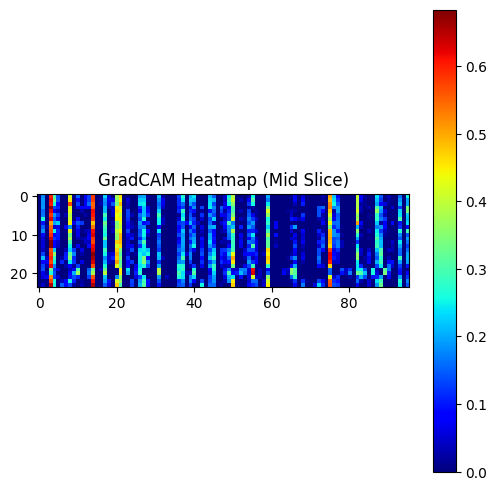

In [17]:
import matplotlib.pyplot as plt

mid = cam.shape[0] // 2  # middle slice

plt.figure(figsize=(6,6))
plt.imshow(cam[mid], cmap='jet')
plt.colorbar()
plt.title("GradCAM Heatmap (Mid Slice)")
plt.show()


🎯 GradCAM attached to: LayerNorm((96,), eps=1e-05, elementwise_affine=True)


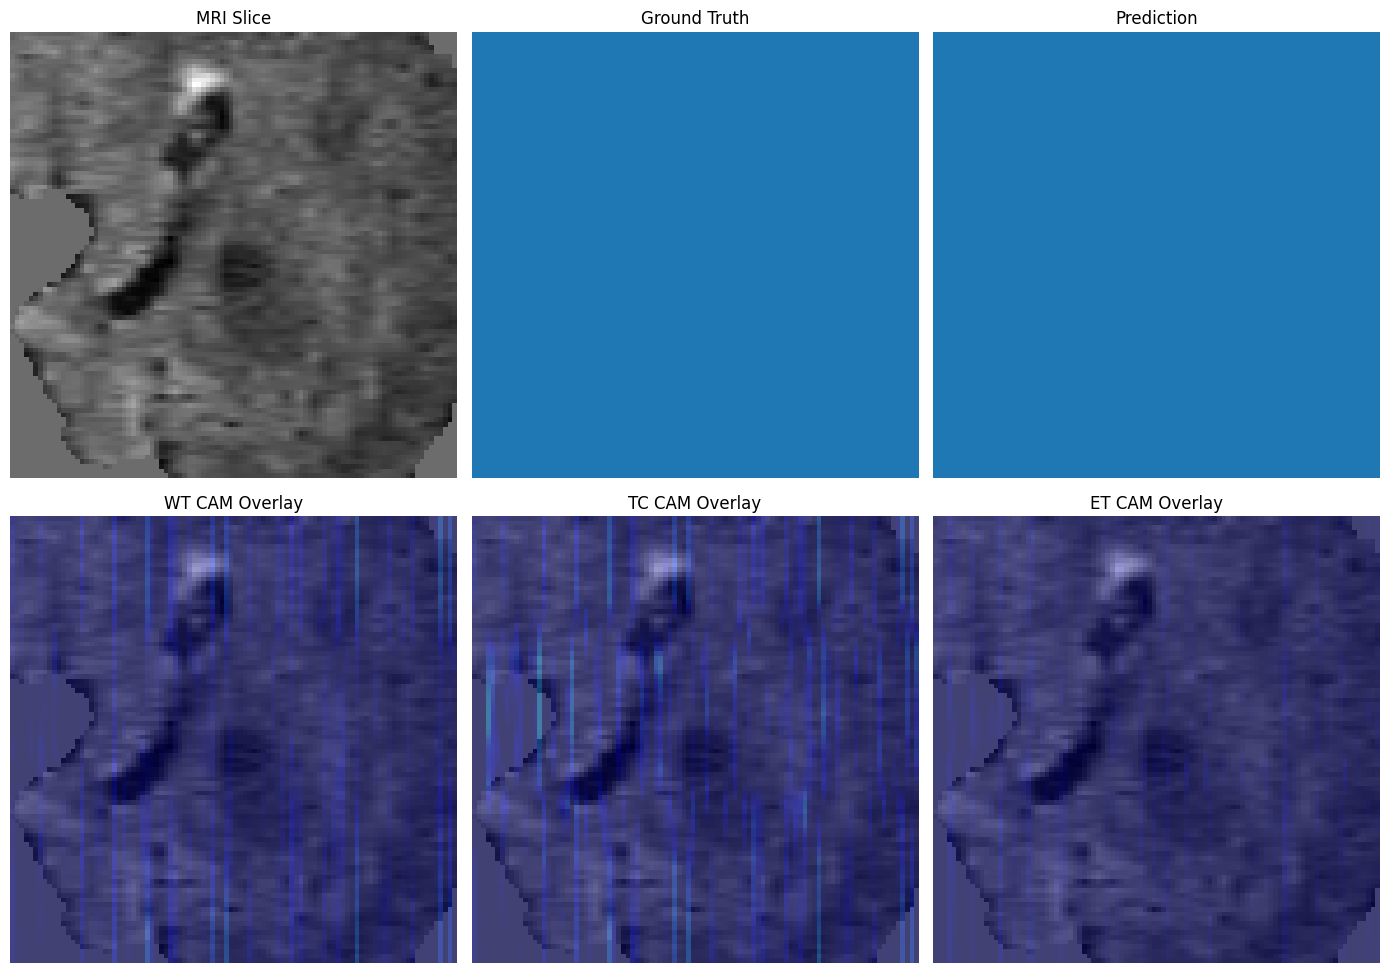

In [18]:
# ===============================================
# 📌 GRADCAM + MULTI-CLASS EXPLAINABILITY (WT-TC-ET)
# ===============================================

import torch, numpy as np, cv2, matplotlib.pyplot as plt

# -----------------------------------------------
# 🔗 Attach Grad-CAM Hooks (do this ONCE)
# -----------------------------------------------
target_layer = model.swinViT.layers2[0].blocks[-1].norm1  # Good mid-depth CAM layer

gradients = []
activations = []

def save_activation(module, inp, out):
    activations.append(out)

def save_gradient(module, grad_in, grad_out):
    gradients.append(grad_out[0])

target_layer.register_forward_hook(save_activation)
target_layer.register_full_backward_hook(save_gradient)

print("🎯 GradCAM attached to:", target_layer)

# -----------------------------------------------------
# 🧠 Function to generate CAM for a given class label
#   Class indices:
#      1 = WT (Whole Tumor)
#      2 = TC (Tumor Core)
#      3 = ET (Enhancing Tumor)
# -----------------------------------------------------
def build_cam(prob_output, cls_index):
    model.zero_grad()
    score = prob_output[cls_index].mean()
    score.backward(retain_graph=True)

    act = activations[-1]
    grad = gradients[-1]

    # Remove batch if present
    if act.dim() == 5:
        act = act[0]
        grad = grad[0]

    act = act.detach().cpu().numpy()
    grad = grad.detach().cpu().numpy()

    weights = grad.mean(axis=(1,2,3), keepdims=True)  # average gradient per channel
    cam = np.maximum((weights * act).sum(axis=0), 0)  # weighted sum
    cam = cam / (cam.max() + 1e-8)  # normalize 0-1
    return cam  # shape: (D, H, W)

# -----------------------------------------------------
# 🎨 Overlay utility: CAM + MRI Slice
# -----------------------------------------------------
def overlay(cam, base_img):
    base = cv2.normalize(base_img, None, 0, 255, cv2.NORM_MINMAX)
    base = np.uint8(base)

    cam_resized = cv2.resize(cam, (base.shape[1], base.shape[0]))

    heat = cv2.applyColorMap(np.uint8(cam_resized * 255), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

    base_rgb = np.stack([base]*3, axis=-1)
    return cv2.addWeighted(base_rgb, 0.6, heat, 0.4, 0)

# -----------------------------------------------------
# 🧪 Generate CAM for a sample from Validation
# -----------------------------------------------------
sample = next(iter(val_loader))
img = sample["image"].to(device)
gt = sample["seg"][0,0].cpu().numpy()  # ground truth segmentation

model.eval()
output = model(img)
prob = output.softmax(1)[0]  # class probabilities

# Compute CAMs for WT, TC, ET
cam_WT = build_cam(prob, 1)
cam_TC = build_cam(prob, 2)
cam_ET = build_cam(prob, 3)

# Pick middle slice
slice_id = cam_WT.shape[0] // 2
mri_slice = img[0,0, slice_id].detach().cpu().numpy()  # FLAIR view for visualization
pred_slice = torch.argmax(prob, 0).cpu().numpy()[slice_id]

# Overlay CAMs on MRI
ov_WT = overlay(cam_WT[slice_id], mri_slice)
ov_TC = overlay(cam_TC[slice_id], mri_slice)
ov_ET = overlay(cam_ET[slice_id], mri_slice)

# -----------------------------------------------------
# 📌 DISPLAY ALL VISUALS
# -----------------------------------------------------
plt.figure(figsize=(14,10))

plt.subplot(2,3,1); plt.title("MRI Slice"); plt.imshow(mri_slice, cmap='gray'); plt.axis('off')
plt.subplot(2,3,2); plt.title("Ground Truth"); plt.imshow(gt[slice_id], cmap='tab20'); plt.axis('off')
plt.subplot(2,3,3); plt.title("Prediction"); plt.imshow(pred_slice, cmap='tab20'); plt.axis('off')

plt.subplot(2,3,4); plt.title("WT CAM Overlay"); plt.imshow(ov_WT); plt.axis('off')
plt.subplot(2,3,5); plt.title("TC CAM Overlay"); plt.imshow(ov_TC); plt.axis('off')
plt.subplot(2,3,6); plt.title("ET CAM Overlay"); plt.imshow(ov_ET); plt.axis('off')

plt.tight_layout()
plt.show()
